# Problem Set 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

> <font color='red'>I worked with Alex Robson on parts of this problem set.</font>

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on bCourses). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from bCourses. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 1|
|progresa |treatment =1|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|schooling in 1997|

---

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Present summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

In [2]:
# read in data
sample = pd.read_csv('progresa_sample.csv')

# find columns that contain non-numeric data
str_cols = sample.select_dtypes(include='object').columns

# check to see that these columns can be converted to binary (i.e. only two unique values), then convert
for str_col in str_cols:
    if len(sample[str_col].unique())==2:
        print('can be converted to binary : {}'.format(str_col))
        b0 = sample[str_col].unique()[0]
        b1 = sample[str_col].unique()[1]
        sample.loc[sample[str_col]==b0, str_col] = 0
        sample.loc[sample[str_col]==b1, str_col] = 1
        print('    converted to 0 : {}'.format(b0))
        print('    converted to 1 : {}'.format(b1))
    else:
        print('cannot be converted to binary')

can be converted to binary : poor
    converted to 0 : pobre
    converted to 1 : no pobre
can be converted to binary : progresa
    converted to 0 : 0
    converted to 1 : basal


In [3]:
# create a new dataframe just for the summary stats
summary_stats_cols = ['variable','mean','standard deviation']
summary_stats = pd.DataFrame(columns=summary_stats_cols)

# compute the statistics and add to the dataframe
for col in sample.columns:
    if col not in ['year', 'folnum', 'village']:
        add_row = pd.DataFrame([[col, np.mean(sample[col]), np.std(sample[col])]],
                               columns=summary_stats_cols)
        summary_stats = summary_stats.append(add_row, ignore_index=True)
        
# sort alphabetically
summary_stats.sort_values('variable', inplace=True)
summary_stats.reset_index(drop=True, inplace=True)
    
# show
summary_stats

,variable,mean,standard deviation
0,age,11.366460,3.167723
1,dist_cap,147.674452,76.062641
2,dist_sec,2.418910,2.234094
3,fam_n,7.215715,2.352885
4,grc,3.963537,2.499046
5,grc97,3.705372,2.572371
6,hohage,44.436717,11.620296
7,hohedu,2.768104,2.656089
8,hohsex,0.925185,0.263093
9,hohwag,586.985312,788.128563


> <font color='red'>Note that many of these variables are not continuous (e.g. sex), and so the utility of the standard deviation is limited for these variables.</font>

### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages? Hint: Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').

Present your results in a single table with the following columns and 14 (or so) rows (alphabetized by variable name):

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|


In [4]:
# pull out the baseline data for the poor, separating treatment and control villages
sample97untreated = sample[(sample['year']==97) & (sample['poor']==0) & (sample['progresa']==0)].copy()
sample97treated = sample[(sample['year']==97) & (sample['poor']==0) & (sample['progresa']==1)].copy()
# note that in my dataframe, poor==0 (not 1, see above)

# create a new dataframe just for the baseline differences
baseline_diff_cols = ['variable',
                      'mean - treatment',
                      'mean - control',
                      'difference (treatment-control)',
                      'ttest p-value']
baseline_diff = pd.DataFrame(columns=baseline_diff_cols)

# compute the values and add to the dataframe
for col in sample.columns:
    if col not in ['year', 'folnum', 'village', 'sc97', 'grc97', 'poor', 'progresa']:
        # do the ttest, and ignore any NaN values
        stat, pval = stats.ttest_ind(sample97treated[~sample97treated[col].isnull()][col],
                                     sample97untreated[~sample97untreated[col].isnull()][col],
                                     equal_var=False)

        add_row = pd.DataFrame([[col,
                                 np.mean(sample97treated[col]),
                                 np.mean(sample97untreated[col]),
                                 np.mean(sample97treated[col])-np.mean(sample97untreated[col]),
                                 pval]],
                               columns=baseline_diff_cols)
        baseline_diff = baseline_diff.append(add_row, ignore_index=True)
        
# sort alphabetically
baseline_diff.sort_values('variable', inplace=True)
baseline_diff.reset_index(drop=True, inplace=True)
    
# show
baseline_diff

,variable,mean - treatment,mean - control,difference (treatment-control),ttest p-value
0,age,10.716991,10.742023,-0.025032,4.783633e-01
1,dist_cap,150.829074,153.769730,-2.940656,1.146482e-03
2,dist_sec,2.453122,2.507662,-0.054540,4.266282e-02
3,fam_n,7.281327,7.302469,-0.021142,4.289667e-01
4,grc,3.531599,3.543050,-0.011450,6.895228e-01
5,hohage,43.648828,44.276918,-0.628090,2.259461e-06
6,hohedu,2.663139,2.590348,0.072791,1.038219e-02
7,hohsex,0.924656,0.922947,0.001709,5.721253e-01
8,hohwag,544.339544,573.163558,-28.824015,3.287285e-04
9,indig,0.325986,0.332207,-0.006222,2.459021e-01


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline?

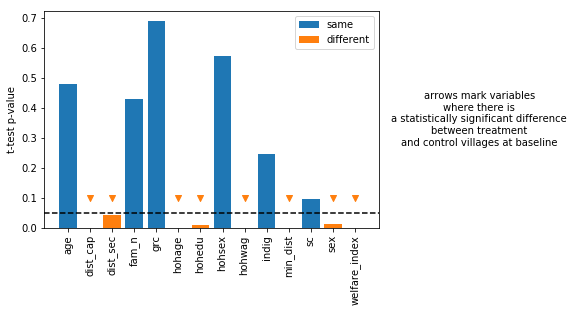

In [5]:
fig, ax = plt.subplots()

# identify those variables where we cannot reject the null hypothesis of identical average scores
same_inds = np.where(baseline_diff['ttest p-value']>0.05)[0]
diff_inds = np.where(baseline_diff['ttest p-value']<=0.05)[0]

# plot
ax.bar(same_inds, baseline_diff.loc[same_inds]['ttest p-value'], color='C0', label='same')
ax.bar(diff_inds, baseline_diff.loc[diff_inds]['ttest p-value'], color='C1', label='different')
ax.scatter(diff_inds, np.ones(len(diff_inds))*0.1, marker='v', c='C1')
ax.axhline(0.05, c='k', ls='--')
ax.set_xticks(np.arange(len(baseline_diff.index)))
ax.set_xticklabels(baseline_diff['variable'], rotation=90)
ax.set_ylabel('t-test p-value')
ax.legend()
ax.text(1.3, 0.5, 'arrows mark variables\n'+
                  'where there is\n'+
                  'a statistically significant difference\n'+
                  'between treatment\n'+
                  'and control villages at baseline',
        horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)

plt.show(fig)

> <font color='red'>As we can see in the plot above, the t-test computes p-values less than 0.05 for several variables (namely dist_cap, dest_sec, hohage, hohedu, hohwag, min_dist, sex, and welfare_index). T-test p-values below 0.05 indicate that we can reject the null hypothesis of identical average scores at the 95% confidence level, and therefore indicate that there are statistically significant difference between treatment and control villages at baseline for these variables. Note, however, that school enrollment (`sc`) barely does not pass the significance threshold.</font>

* B: Why does it matter if there are differences at baseline?

> <font color='red'>Noticing that there are differences at baseline for certain variables is critical for determining which experimental design is appropriate for assessing the effect of treatment on demographic characteristics. In particular, these difference imply that differences between treatment and control villages after treatment cannot be simply attributed to the treatment. Instead, these differences at baseline must be accounted for when evaluating the effect of treatment.</font>

* C: What does this imply about how to measure the impact of the treatment?

> <font color='red'>For the reasons described above, difference at baseline automatically implies that we cannot use the "single difference: treatment vs. control" approach. Instead, another approach is required. For instance, the "double difference" approach lends itself well to the type of data that was collected here, especially since the difference at baseline is explicitly accounted for.</font>

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average enrollment rate in 1997. Create a scatterplot that shows this relationship. What do you notice?

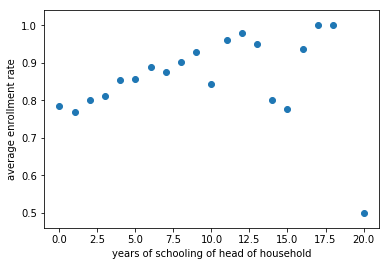

In [6]:
# pull out data for 1997
sample97 = sample[(sample['year']==97) & (sample['poor']==0)].copy()

# get the household head education levels
hohedu_levels = sample97['hohedu'].unique()

# compute the average enrollment rate for each level
hohedu_level_sc_means = np.array([])
for level in hohedu_levels:
    sc_mean = np.mean(sample97[sample97['hohedu']==level]['sc'])
    hohedu_level_sc_means = np.append(hohedu_level_sc_means, sc_mean)
    
# plot
fig, ax = plt.subplots()

ax.scatter(hohedu_levels, hohedu_level_sc_means)
ax.set_xlabel('years of schooling of head of household')
ax.set_ylabel('average enrollment rate')

plt.show(fig)

In [7]:
# calculate the correlation coefficient, but exclude the outlier
coeff, pval = stats.stats.pearsonr(hohedu_levels[hohedu_levels!=20], hohedu_level_sc_means[hohedu_levels!=20])

print('correlation coefficient = {:3.2}'.format(coeff))
print('p-value                 = {:3.2}'.format(pval))

correlation coefficient = 0.64
p-value                 = 0.0031


> <font color='red'>As we can see from the plot and correlation coefficient above, there is a strong positive correlation between the years of schooling that the head of household received and the enrollment rate (if we ignore the outlier at 20 years of head of household schooling, which only includes two data points). The associated p-value is much smaller than 0.05, indicating that we can be confident about this correlation at the 95% confidence level.</font>

### 1.5 Graphical exploration, part 2

Visualize the distribution of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households). Does there appear to be a difference? Is this difference statistically significant?

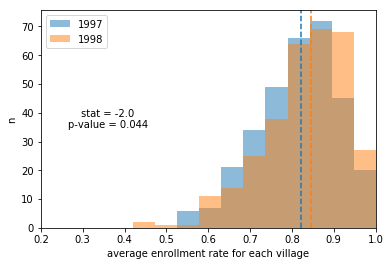

In [8]:
# pull out the two populations we want to compare
sample97treated = sample[(sample['year']==97) & (sample['poor']==0) & (sample['progresa']==1)].copy()
sample98treated = sample[(sample['year']==98) & (sample['poor']==0) & (sample['progresa']==1)].copy()
# note that in my dataframe, poor==0 (not 1, see above)

# get the unique villages
villages = sample97treated['village'].unique()

# compute the average enrollment rate for each village, before and after treatment
village97_sc_means = np.array([])
village98_sc_means = np.array([])
for village in villages:
    sc97_mean = np.mean(sample97treated[sample97treated['village']==village]['sc'])
    sc98_mean = np.mean(sample98treated[sample98treated['village']==village]['sc'])
    village97_sc_means = np.append(village97_sc_means, sc97_mean)
    village98_sc_means = np.append(village98_sc_means, sc98_mean)
    
# t-test
stat, pval = stats.ttest_ind(village97_sc_means,village98_sc_means,equal_var=False)
    
# plot
fig, ax = plt.subplots()

# make sure bins are consistent between histograms
bins = np.linspace(0,1,20)

# histograms
ax.hist(village97_sc_means, bins=bins, color='C0', alpha=0.5, label='1997')
ax.hist(village98_sc_means, bins=bins, color='C1', alpha=0.5, label='1998')

# means
ax.axvline(np.mean(sample97treated['sc']), c='C0', ls='--')
ax.axvline(np.mean(sample98treated['sc']), c='C1', ls='--')

# t-test results
ax.text(0.2, 0.5, 'stat = {:3.2}\np-value = {:3.2}'.format(stat,pval),
        horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)

# prettify
ax.legend()
ax.set_xlabel('average enrollment rate for each village')
ax.set_ylabel('n')
ax.set_xlim(0.2,1)

plt.show(fig)

> <font color='red'>Looking at the plot created above, there does appear to be a slight difference between the two distributions. In particular, the distribution of the average enrollment rate for poor treatment households in 1998 appears to be slightly shifted to higher values compared to that for poor treatment households in 1997. The mean values, although similar, also reflect this shift. Our t-test also confirms this observation, although the p-value just passes the 95% significance threshold. If we neglect all other considerations and take this observation at face value, it suggests that the treatment did increase school enrollment in poor villages. However, there may have been factors other than the treatment that increased school enrollment between 1997 and 1998.</font>

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on the social and economic outcomes of individuals in Mexico. We will focus on the impact of the program on the poor (those with poor=='pobre'), since only the poor were eligible to receive the PROGRESA assistance.

### 2.1 Simple differences: T-test

Begin by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment), calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages. Use a t-test to determine if this difference is statistically significant. What do you conclude?

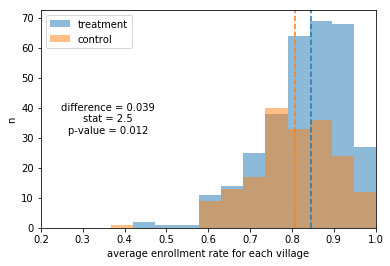

In [9]:
# pull out the two populations we want to compare
sample98treated = sample[(sample['year']==98) & (sample['poor']==0) & (sample['progresa']==1)].copy()
sample98untreated = sample[(sample['year']==98) & (sample['poor']==0) & (sample['progresa']==0)].copy()
# note that in my dataframe, poor==0 (not 1, see above)

# get the unique villages
treated_villages98 = sample98treated['village'].unique()
untreated_villages98 = sample98untreated['village'].unique()

# compute the average enrollment rate for each village in the treatment and control
treated_village98_sc_means = np.array([])
for village in treated_villages98:
    sc98_mean = np.mean(sample98treated[sample98treated['village']==village]['sc'])
    treated_village98_sc_means = np.append(treated_village98_sc_means, sc98_mean)
    
untreated_village98_sc_means = np.array([])
for village in untreated_villages98:
    sc98_mean = np.mean(sample98untreated[sample98untreated['village']==village]['sc'])
    untreated_village98_sc_means = np.append(untreated_village98_sc_means, sc98_mean)
    
# t-test
stat, pval = stats.ttest_ind(treated_village98_sc_means,untreated_village98_sc_means,equal_var=False)
    
# plot
fig, ax = plt.subplots()

# make sure bins are consistent between histograms
bins = np.linspace(0,1,20)

# histograms
ax.hist(treated_village98_sc_means, bins=bins, color='C0', alpha=0.5, label='treatment')
ax.hist(untreated_village98_sc_means, bins=bins, color='C1', alpha=0.5, label='control')

# means
ax.axvline(np.mean(sample98treated['sc']), c='C0', ls='--')
ax.axvline(np.mean(sample98untreated['sc']), c='C1', ls='--')
effect_2_1 = np.mean(sample98treated['sc']) - np.mean(sample98untreated['sc'])

# t-test results
ax.text(0.2, 0.5, 'difference = {:3.2}\nstat = {:3.2}\np-value = {:3.2}'.format(effect_2_1,stat,pval),
        horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)

# prettify
ax.legend()
ax.set_xlabel('average enrollment rate for each village')
ax.set_ylabel('n')
ax.set_xlim(0.2,1)

plt.show(fig)

> <font color='red'>Looking at the histograms above, the distribution for treatment villages does appear to be shifted to higher values relative to the control villages. The mean for the treatment villages is also slightly higher than that of the control villages. Our t-test also confirms this observation, with the p-value well under the 95% significance threshold. Again, if we ignore all other considerations and take this observation at face value, it suggests that the treatment did increase school enrollment in poor villages. However, we must remember that there was a different at baseline between the treatment and control villages, and so without explicitly accounting for this, we cannot conclude based on the histogram shown above that the treatment did increase school enrollment in poor villages.</font>

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. For now, do not include any other variables in your regression. Discuss the following:

> <font color='red'>The equation we will be implementing is:
>
> $$
  Y_{i} = \alpha + \beta T_{i} + \epsilon_{i}
  $$
>
> where $Y_{i}$ is school enrollment, $T_{i}$ is a binary variable of treatment/control, and $i$ represents an individual household. This means that $\alpha$ represents average school enrollment for all control households, and $\beta$ represents the average change in school enrollment for treatment households relative to control households.</font>

In [10]:
# pull out data for 1998
sample98 = sample[(sample['year']==98) & (sample['poor']==0)].copy()
# note that in my dataframe, poor==0 (not 1, see above)

# do the regression
result = smf.ols(formula = "sc ~ progresa", data = sample98).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Mon, 17 Sep 2018   Prob (F-statistic):           6.64e-17
Time:                        18:02:11   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8076      0.004    220.676      0.0

In [11]:
# pull out key values
alpha = result.params[0]
beta = result.params[1]
effect_2_2 = beta
alpha_p = result.pvalues[0]
beta_p = result.pvalues[1]

# print
print('alpha = {:4.3f}, p-value = {:4.3f}'.format(alpha, alpha_p))
print('beta  = {:4.3f}, p-value = {:4.3f}'.format(beta, beta_p))
print('---')
print('average change = {:4.3}%'.format((beta/alpha)*100))

alpha = 0.808, p-value = 0.000
beta  = 0.039, p-value = 0.000
---
average change = 4.81%


* Based on this model, how much did Progresa increase or decrease the likelihood of a child enrolling? Make sure you express you answer in a sentence that your grandmother could understand, using appropriate units.

> <font color='red'>If we assume that the assumptions underlying this simple difference regression model are correct (which they aren't), Progresa increased the likelihood of a child enrolling by 4.81\%.</font>

* How does your regression estimate compare to your t-test estimate from part 2.1?

In [12]:
# compare 2.1 to 2.2
print('2.2 effect = {:4.3f}'.format(effect_2_2))
print('2.1 effect = {:4.3f}'.format(effect_2_1))
print('difference = {:4.3f}'.format(effect_2_2-effect_2_1))

2.2 effect = 0.039
2.1 effect = 0.039
difference = -0.000


> <font color='red'>As we can see above, the difference in means between treatment and control households is identical to the calculated $\beta$ (neglecting machine precision error). This is expected, since $\beta$ represents the average change in school enrollment for treatment households relative to control households (i.e. the linear regression calculates the difference in means between treatment and control households, just in another way).</font>

* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero?

> <font color='red'>If we assume that the assumptions underlying this simple difference regression model are correct, we can reject the null hypothesis at the 95\% confidence level that the treatment effects are zero, as we see a positive $\beta$ with an associated p-value orders of magnitude smaller than 0.05.</font>

* What is the counterfactual assumption underlying this regression?

> <font color='red'>The counterfactual assumption is that, in the absence of treatment, the treatment households would have the same rate of school enrollment as the control households. We have already shown in part 1.3 that this is a bad assumption to make: there are differences in baseline between the treatment and control groups.</font>

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, welfare index, indigenous, etc.

> <font color='red'>The equation we will be implementing is:
>
> $$
  Y_{i} = \alpha + \beta T_{i} + \gamma_{j} X_{ij} + \epsilon_{i}
  $$
>
> where $X_{ij}$ are the $j$ control variables for the $i$ households.</font>

In [13]:
# do the regression with control variables
formula = "sc ~ progresa +"+\
          "sex +"+\
          "indig +"+\
          "dist_sec +"+\
          "grc +"+\
          "fam_n +"+\
          "min_dist +"+\
          "dist_cap +"+\
          "hohedu +"+\
          "hohwag +"+\
          "welfare_index +"+\
          "hohsex +"+\
          "hohage +"+\
          "age"

result = smf.ols(formula = formula, data = sample98).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     847.0
Date:                Mon, 17 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:02:11   Log-Likelihood:                -6928.7
No. Observations:               27200   AIC:                         1.389e+04
Df Residuals:                   27185   BIC:                         1.401e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.6540      0.020     84.276

In [14]:
# pull out key values
alpha = result.params[0]
beta = result.params[1]
effect_2_3 = beta
alpha_p = result.pvalues[0]
beta_p = result.pvalues[1]

# print
print('alpha = {:4.3f}, p-value = {:4.3f}'.format(alpha, alpha_p))
print('beta  = {:4.3f}, p-value = {:4.3f}'.format(beta, beta_p))

alpha = 1.654, p-value = 0.000
beta  = 0.032, p-value = 0.000


* How do the controls affect the point estimate of treatment effect?

> <font color='red'>The control variables slightly decrease $\beta$ relative to the simple difference regression model (0.032 vs. 0.039). As we can see from the coefficients above, several control variables (e.g. `sex`, `indig`, `dist_sec`, ...) are significantly correlated with school enrollment (i.e. they have p-values less than 0.05 and the magnitude of their coefficients are large). In fact, the magnitude of the effect of some of these control variables (e.g. `sex`), is actually larger than the magnitude of the effect of treatment, highlighting the importance of taking these control variables into account. In other words, by accounting for these correlations, we come closer to isolating the effect of treatment on school enrollment. Therefore, the smaller $\beta$ suggests that the true effect of treatment on school enrollment is smaller than the estimate made with the simple difference regression model.
>
> Also note that, by including continuous control variables into the regression, the intercept (i.e. $\alpha$) becomes not physically interpretable on its own, unlike in section 2.1. In this multiple regression, the intercept ends up representing the non-realistic situation where all the control variables have a value of zero, and thus ends up with a non-realistic value >1.
</font>

* How do the controls affect the standard error on the treatment effect?

> <font color='red'>The standard error on $\beta$ is slightly smaller in the multiple regression than in the simple difference regression model (0.004 vs. 0.005). If our control variables are correlated with school enrollment (which they are, as discussed above) and treatment is actually correlated with school enrollment, then this is expected, since the multiple regression will remove the effect of the control variables, resulting in a more accurate quantification of the correlation between treatment and school enrollment.</font>

* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

> <font color='red'>As discussed above, the smaller $\beta$ in the multiple regression model relative to the simple difference regression model suggests that the true effect of treatment on school enrollment is smaller than the estimate made with the simple difference regression model, since the multiple regression model accounts for other factors that also correlate with school enrollment. This statement can be viewed another way: because there is a difference at baseline for several variables between treatment and control households, and because these variables correlate with school enrollment, the effect of treatment cannot be correctly isolated just by examining school enrollment between treatment and control villages. However, the multiple regression approach also does not truly isolate the effect of treatment, since control variables can never account for all possible non-treatment factors that influence school enrollment (i.e. there are factors that cannot be easily observed). Furthermore, multiple regression does not account for time-variant changes in non-treatment factors between treatment and control villages. Nevertheless, as discussed above, this approach is closer to isolating the effect of treatment on school enrollment since we are explicitly accounting for at least some of the non-treatment factors that we know are correlated with school enrollment.</font>

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in control villages. The difference between these two differences is your estimate.

In [15]:
# create a dataframe for better visualization
DID_table = pd.DataFrame(columns=['group','mean sc 97','mean sc 98','difference'])

# add control row
add_row = pd.DataFrame([['control',
                         np.mean(sample97untreated['sc']),
                         np.mean(sample98untreated['sc']),
                         np.mean(sample98untreated['sc'])-np.mean(sample97untreated['sc'])]],
                       columns=['group','mean sc 97','mean sc 98','difference'])
DID_table = DID_table.append(add_row, ignore_index=True)

# add treatment row
add_row = pd.DataFrame([['treatment',
                         np.mean(sample97treated['sc']),
                         np.mean(sample98treated['sc']),
                         np.mean(sample98treated['sc'])-np.mean(sample97treated['sc'])]],
                       columns=['group','mean sc 97','mean sc 98','difference'])
DID_table = DID_table.append(add_row, ignore_index=True)

# show
DID_table

,group,mean sc 97,mean sc 98,difference
0,control,0.815186,0.807637,-0.007549
1,treatment,0.822697,0.846479,0.023782


In [16]:
# difference-in-difference estimate
DID_estimate = DID_table['difference'][1] - DID_table['difference'][0]
effect_2_4 = DID_estimate
print('difference in difference estimate = {:4.3f}'.format(DID_estimate))

difference in difference estimate = 0.031


* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?

> <font color='red'>As shown above, the estimated impact from the difference-in-difference (DID) approach is a 0.031 increase in school enrollment. The simple difference method applied earlier instead estimates an impact of 0.039. As discussed in 2.1 and 2.2, the simple difference approach has multiple problems associated with it. The DID, on the other hand, attempts to account for the difference in baseline between the treatment and control households, as well as time-variant changes in school enrollment that are not associated with treatment. Therefore, the DID estimate is closest to the "truth" of all approaches used so far.</font>

* What is the counterfactual assumption underlying this estimate?

> <font color='red'>The counterfactual assumption is that, in the absence of treatment, the change in school enrollment for the treatment group between 1997 and 1998 would have been the same as the change in school enrollment for the control group over the same time period. This assumption is not terrible, but we have shown already that there are differences at baseline between the treatment and control groups in factors that correlate with school enrollment. Therefore, if these non-treatment factors changed differently for the treatment and control groups between 1997 and 1998, then the counterfactual assumption would not hold true.</font>

### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment effects of the program in a difference-in-differences framework. Include at least 5 control variables.

> <font color='red'>The equation we will be implementing is:
>
> $$
  Y_{i} = \alpha + \beta T_{i} + \gamma_{j} t_{i} + \delta(T_{i}t_{i}) + \rho X_{ij} + \epsilon_{i}
  $$
>
> where $T_{i}$ is a binary variable for treatment, $t_{i}$ is a binary variable for before/after, and $X_{ij}$ are the $j$ control variables for the $i$ households.</font>

In [17]:
# pull out the population we want
samplepoor = sample[sample['poor']==0].copy()
# note that in my dataframe, poor==0 (not 1, see above)

# do the regression without the control variables first
formula = "sc ~ progresa * C(year)"

result = smf.ols(formula = formula, data = samplepoor).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     28.31
Date:                Mon, 17 Sep 2018   Prob (F-statistic):           2.76e-18
Time:                        18:02:11   Log-Likelihood:                -26242.
No. Observations:               58372   AIC:                         5.249e+04
Df Residuals:                   58368   BIC:                         5.253e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

> <font color='red'>Here I just show that, without control variables, the effect estimated in the tabular DID is identical to the effect estimated in the regression DID ($\delta$, or `progresa:C(year)[T.98]` = 0.0313 in the table above).</font>

In [18]:
# pull out the population we want
samplepoor = sample[sample['poor']==0].copy()
# note that in my dataframe, poor==0 (not 1, see above)

# do the regression with control variables
formula = "sc ~ progresa * C(year) +"+\
          "sex +"+\
          "indig +"+\
          "dist_sec +"+\
          "grc +"+\
          "fam_n +"+\
          "min_dist +"+\
          "dist_cap +"+\
          "hohedu +"+\
          "hohwag +"+\
          "welfare_index +"+\
          "hohsex +"+\
          "hohage +"+\
          "age"

result = smf.ols(formula = formula, data = samplepoor).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     1631.
Date:                Mon, 17 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:02:11   Log-Likelihood:                -15320.
No. Observations:               57938   AIC:                         3.067e+04
Df Residuals:                   57921   BIC:                         3.083e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

In [19]:
# pull out key values
alpha = result.params[0]
delta = result.params[3]
effect_2_5 = delta
alpha_p = result.pvalues[0]
delta_p = result.pvalues[3]

# print
print('alpha = {:4.3f}, p-value = {:4.3f}'.format(alpha, alpha_p))
print('delta = {:4.3f}, p-value = {:4.3f}'.format(delta, delta_p))

alpha = 1.616, p-value = 0.000
delta = 0.029, p-value = 0.000


* What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.

> <font color='red'>As shown above, the estimated impact from this regression DID approach is a 0.029 average increase in school enrollment between 1997 and 1998 for the treatment (Progresa) households relative to the control households. In effect, we arrive at this number by doing a multiple linear regression, but including an interaction term between the treatment and before/after binary variables (as shown in the equation above). It is the coefficient of this interaction term that can be interpreted as the estimated effect. Both the standard error and the p-value for this coefficient are low, indicating that the correlation between the treatment and school enrollment is statistically significant.</font>

* How do these estimates of the treatment effect compare to the estimates based on the simple difference?

> <font color='red'>In the simple difference approach, the estimated effect was 0.039, which is a higher value than the effect estimated here. Again, this is because the simple difference approach does not account for the effect of non-treatment factors on school enrollment between the control and treatment households. Given that the DID estimate does account for these non-treatment factors and estimates a lower treatment effect, it suggests that differences in non-treatment factors (i.e. in the absence of treatment) between treatment and control groups result in higher school enrollment for the control group relative to the treatment group.</font>

* How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?

> <font color='red'>In the tabular DID approach, we estimated an impact of 0.031, which is a slightly higher value than the effect estimated here. This difference arises from the use of control variables (as shown above when we do and do not include the control variables in the regression), which explicitly attempt to account for non-treatment factors. However, the problems with using control variables are identical to those described in 2.3: the approach does not truly isolate the effect of treatment, since control variables can never account for all possible non-treatment factors that influence school enrollment. Nevertheless, the difference between the tabular and regression DID approaches suggests that the non-treatment variables increase school enrollment more for the control households than for the treatment households.</font>

* What is the counterfactual assumption underlying this regression?

> <font color='red'>The counterfactual assumption is that, in the absence of treatment, the change in school enrollment for the treatment group between 1997 and 1998 would have been the same as the change in school enrollment for the control group over the same time period, once we remove the estimated effect of the non-treatment factors (i.e. the control variables) on school enrollment.</font>

### 2.6 Spillover effects

Thus far, we have focused on the impact of PROGRESA on poor households. Repeat your analysis in 2.5, instead focusing on the impact of PROGRESA on non-poor households.

> <font color='red'>Same equation as 2.5, except we apply to the non-poor instead:</font>

In [20]:
# pull out the population we want
samplerich = sample[sample['poor']==1].copy()
# note that in my dataframe, poor==0 (not 1, see above)

# do the regression with control variables
formula = "sc ~ progresa * C(year) +"+\
          "sex +"+\
          "indig +"+\
          "dist_sec +"+\
          "grc +"+\
          "fam_n +"+\
          "min_dist +"+\
          "dist_cap +"+\
          "hohedu +"+\
          "hohwag +"+\
          "welfare_index +"+\
          "hohsex +"+\
          "hohage +"+\
          "age"

result = smf.ols(formula = formula, data = samplerich).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     327.3
Date:                Mon, 17 Sep 2018   Prob (F-statistic):               0.00
Time:                        18:02:11   Log-Likelihood:                -3267.3
No. Observations:               10319   AIC:                             6569.
Df Residuals:                   10302   BIC:                             6692.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

In [21]:
# pull out key values
alpha = result.params[0]
delta = result.params[3]
effect_2_5 = delta
alpha_p = result.pvalues[0]
delta_p = result.pvalues[3]

# print
print('alpha = {:7.3f}, p-value = {:4.3f}'.format(alpha, alpha_p))
print('delta = {:7.3f}, p-value = {:4.3f}'.format(delta, delta_p))

alpha =   1.724, p-value = 0.000
delta =  -0.003, p-value = 0.800


* Do you observe any impacts of PROGRESA on the non-poor?

> <font color='red'>$\delta$ is very small at -0.003, the standard error on this coefficient is large (0.013), and the p-value is also large (0.8). Together, these values suggest that there is no significant impact of Progresa on the non-poor.</font>

* Regardless of whether you find evidence of spillovers, describe one or two reasons why PROGRESA *might* have impacted non-poor households. Give concrete examples based on the context in which PROGRESA was implemented.

> <font color='red'>Example 1: households that do not meet the Progresa requirements, but live nearby households that do meet the requirements, may see an increasing number of households around them sending their children to school. This might inspire these non-poor households to also send their children to school, fearing that their children will be "left behind" relative to the rest of the community.
>
> Example 2: as a result of Progresa, smaller/remote schools may experience crowding as school enrollments go up. This may disincentivise non-poor households to send their children to school, since the quality of education may deteriorate as a result of this over crowding.</font>

### 2.7 Summary

* Based on all the analysis you have undertaken to date, do you believe that Progresa had a causal impact on the enrollment rates of poor households in Mexico?

> <font color='red'>Yes - I believe that Progresa had a causal impact on enrollment rates of poor hosueholds in Mexico. Every approach applied above estimated a non-negligible impact of Progresa on school enrollment. This was even the case in the most "nuanced" method applied (the regression DID), which attempted to account for the influence of time-variant non-treatment factors on school enrollment as well as the difference at baseline. Nevertheless, without truly random application of treatment, (and even with it), we cannot be 100% certain that non-observed factors have led to the increase in school enrollment rather than Progresa.</font>

* Describe one other way that you might analyze these data to further investigate the causal impact of Progresa on enrollment, and clearly state the counterfactual assumption you would need to make for that approach to be valid.  *(Hint: Consider using the non-poor in your analysis)*

> <font color='red'>Another way to assess the causal impact of Progresa on enrollment would be to use a regression discontinuity approach. The way in which Progresa was implemented lends itself well to such an approach - subsidies were granted to households that fell below a certain welfare threshold, which was semi-arbitrarily chosen. Therefore, if we assume that households that fall just on either side of the threshold are, in all other aspects, effectively equal, then we can treat the application of the treatment as being pseudo-random for this subset of the study sample. The counterfactual assumption in this case would be that, in the absence of treatment, school enrollment for households that fall just above the welfare threshold would be the same as school enrollment for households that fall just below the welfare threshold.
>
> This approach could be nuanced further by accounting for the dependence between welfare and school enrollment (i.e. substracting the correlation between these two variables). We could further introduce other control variables, and even take a DID approach, making the two groups "just above threshold in treatment village" vs. "just below threshold in treatment village" instead of "treatment village" vs. "control village".</font>